In [62]:
using Agents
using CairoMakie
using Makie

using GeometryBasics
using Random
using LinearAlgebra
using Plots
using KernelDensity
using QuadGK
using Interpolations

In [3]:
@agent Bird ContinuousAgent{2} begin
    #id, pos, vel (inherited)
    speed::Float64 #how far it travels
    cohere_factor::Float64 #group cohesion importance
    separation::Float64 #minimum distance from neighbors
    separate_factor::Float64 #importance of separation maintanence
    match_factor::Float64 #importance of maintaining similar trajectories
    visual_distance::Float64 #how far agent sees/scan neighbors (radius)
    ensemble::Float64 #number of birds in the flock the bird belongs to
end

In [4]:
SEED = 4;

In [82]:
model_iteration = 0

function initialize_model(; n_birds = 100,
    speed = 2.0,
    cohere_factor = 0.4,
    separation = 4.0, separate_factor = 0.25,
    match_factor = 0.02,
    visual_distance = 5.0,
    ensemble = 1,
    extent = (100, 100) )
    
    global model_iteration = 0
    
    space2d = ContinuousSpace(extent; spacing = visual_distance/1.5)
    rng = Random.MersenneTwister(SEED)

    model = ABM(Bird, space2d; rng, scheduler = Schedulers.Randomly())
    
    for _ in 1:n_birds
        vel = Tuple(rand(model.rng, 2) * 2 .- 1)
        add_agent!(
            model,
            vel,
            speed,
            cohere_factor,
            separation,
            separate_factor,
            match_factor,
            visual_distance,
            ensemble
        )
    end
    return model
end


initialize_model (generic function with 1 method)

In [83]:
model = initialize_model()

StandardABM with 100 agents of type Bird
 space: periodic continuous space with (100.0, 100.0) extent and spacing=3.3333333333333335
 scheduler: Agents.Schedulers.Randomly

In [17]:
function agent_step!(bird, model)
    # Obtain the ids of neighbors within the bird's visual distance
    neighbor_ids = nearby_ids(bird, model, bird.visual_distance)
    N = 0
    match = separate = cohere = (0.0, 0.0)
        
    for id in neighbor_ids
        N += 1
        neighbor = model[id].pos
        heading = neighbor .- bird.pos

        # `cohere` computes the average position of neighboring birds
        cohere = cohere .+ heading

        if euclidean_distance(bird.pos, neighbor, model) < bird.separation
            # `separate` repels the bird away from neighboring birds
            separate = separate .- heading
        end
        # `match` computes the average trajectory of neighboring birds
        match = match .+ model[id].vel
                
    end
    N = max(N, 1)
    
    # Normalise results based on model input and neighbor count
    cohere = cohere ./ N .* bird.cohere_factor
    separate = separate ./ N .* bird.separate_factor
    
    match = match ./ N .* bird.match_factor
    # Compute velocity based on rules defined above
    bird.vel = (bird.vel .+ cohere .+ separate .+ match) ./ 2
    bird.vel = bird.vel ./ norm(bird.vel)
    # Move bird according to new velocity and speed
    
    bird.ensemble = length(collect(neighbor_ids))
    
    move_agent!(bird, model, bird.speed)
end

agent_step! (generic function with 1 method)

In [34]:
bird_polygon = Makie.Polygon(Point2f[(-1, -1), (2, 0), (-1, 1)])

function bird_marker(b::Bird)
    φ = atan(b.vel[2], b.vel[1]) #+ π/2 + π
    rotate_polygon(bird_polygon, φ)
end

function Plot_Birds_Iter(model, heat_tmp, iteration_tmp)    
    title_str = "E=$heat_tmp at iter=$iteration_tmp"
    figure, = Agents.abmplot(model; am = bird_marker, aspect = 1, 
                                axis = (; title = title_str, titlesize=20) )
    return figure    
end


Plot_Birds_Iter (generic function with 1 method)

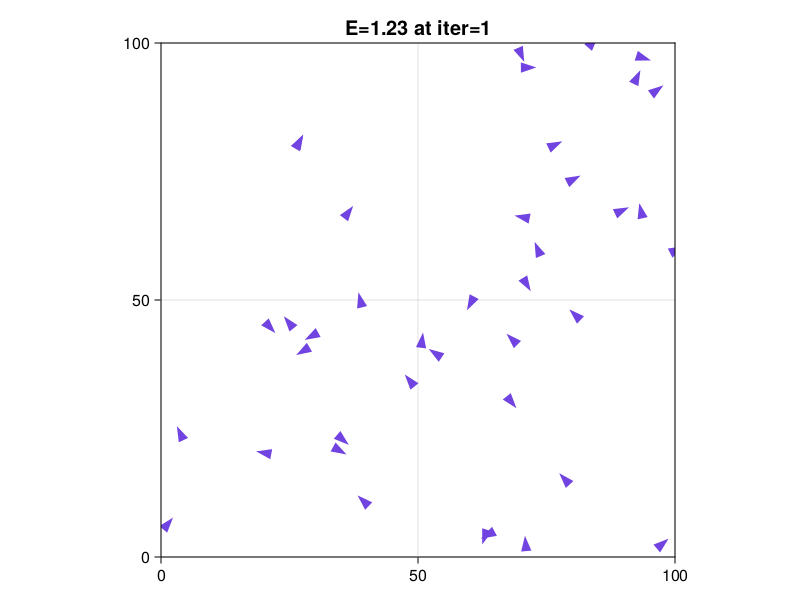

In [35]:
Plot_Birds_Iter(initialize_model(), 1.23, 1)

## Energies



In [36]:
function Model_Ensemble_Energy(model)
    energy = 0
    
    for bird in allagents(model)        
        energy += bird.ensemble
    end
    
    return energy
end

Model_Ensemble_Energy (generic function with 1 method)

In [68]:
function Model_Energy_DistributionFN(model) 
    energies = []
    
    for bird in allagents(model)        
        push!(energies, bird.ensemble)
    end
    
    energies_kde = kde( float.(energies) )
    return energies_kde
end

Model_Energy_DistributionFN (generic function with 1 method)

In [63]:
function Model_Entropy(ensemble_kde)

    # Interpolate the KDE result to create a continuous function
    interp_kde = LinearInterpolation(ensemble_kde.x, ensemble_kde.density, extrapolation_bc=0)

    # Define the function to integrate (the integrand)
    integrand_function = x -> begin
        density = interp_kde(x)
        density > 0 ? density * log(density) : 0
    end

    # Perform numerical integration over the support of the KDE
    entropy, _ = quadgk(integrand_function, minimum(ensemble_kde.x), maximum(ensemble_kde.x))
    entropy = -entropy  # Don't forget to negate the result
    
    return entropy    
end

Model_Entropy (generic function with 1 method)

In [113]:
function dp_dE(E, interp_density)
    delta_E = 1e-5
    return (interp_density(E + delta_E) - interp_density(E)) / delta_E
end


function Model_Temperature(energies_kde)
    interp_density = LinearInterpolation(energies_kde.x, energies_kde.density, extrapolation_bc=0)    
    
    integrand = x -> begin
        pE = interp_density(x)
        dpE = dp_dE(x,interp_density)
        pE > 0 ? dpE * log(pE) : 0
    end
    
    E_min, E_max = extrema(energies_kde.x)
    T, err = quadgk(integrand, E_min, E_max)
    T = -T 
    
    return 1/T
end

Model_Temperature (generic function with 1 method)

In [132]:
function Model_Heat(S_curent, S_prev, T_current, T_prev)
    # Q= |T_i - T_i-1|/ln(|T_i/T_i-1|) * ((S_i - S_i-1))
    Q = ( abs(T_current - T_prev) / log(abs(T_current/T_prev)) ) * (S_curent - S_prev);
    
    return Q
end

Model_Heat (generic function with 1 method)

In [134]:
global S_prev;
global T_prev;

function Model_Thermo_State(model)
    
    energies_kde = Model_Energy_DistributionFN(model)
    S = Model_Entropy(energies_kde)
    T = Model_Temperature(energies_kde)
    
    Q = 0;
    
    if(model_iteration > 0)
        Model_Heat(S, S_prev, T, T_prev)
    end
    
    global S_prev = S;
    global T_prev = T;
    
    return (S=S,T=T,Q=Q)
end

Model_Thermo_State (generic function with 1 method)

In [37]:
function Flock_Model_State(model)
    energy = Model_Ensemble_Energy(model)
    fig_tmp = Plot_Birds_Iter(model, energy, model_iteration)
    return fig_tmp
end

Flock_Model_State (generic function with 1 method)

In [38]:
function model_step!(model)
    global model_iteration += 1    
end

model_step! (generic function with 1 method)

In [39]:
function Step_Num(model)
    return model_iteration 
end

Step_Num (generic function with 1 method)

In [135]:
model = initialize_model()

adata = [ :separation, :speed, :ensemble ]
mdata = [ Step_Num, Model_Ensemble_Energy, Model_Thermo_State, Flock_Model_State ]

step_num = 5
agent_df, model_df = run!(model, agent_step!, model_step!, step_num; adata , mdata)

(600×5 DataFrame
 Row │ step   id     separation  speed    ensemble 
     │ Int64  Int64  Float64     Float64  Float64  
─────┼─────────────────────────────────────────────
   1 │     0      1         4.0      2.0       1.0
   2 │     0      2         4.0      2.0       1.0
   3 │     0      3         4.0      2.0       1.0
   4 │     0      4         4.0      2.0       1.0
   5 │     0      5         4.0      2.0       1.0
   6 │     0      6         4.0      2.0       1.0
   7 │     0      7         4.0      2.0       1.0
   8 │     0      8         4.0      2.0       1.0
   9 │     0      9         4.0      2.0       1.0
  10 │     0     10         4.0      2.0       1.0
  11 │     0     11         4.0      2.0       1.0
  ⋮  │   ⋮      ⋮        ⋮          ⋮        ⋮
 591 │     5     91         4.0      2.0       1.0
 592 │     5     92         4.0      2.0       2.0
 593 │     5     93         4.0      2.0       2.0
 594 │     5     94         4.0      2.0       3.0
 595 │     5   

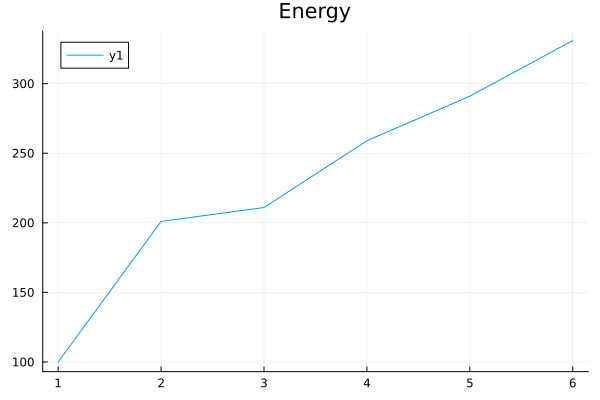

In [136]:
Plots.plot( model_df[ :, :Model_Ensemble_Energy], title="Energy" )

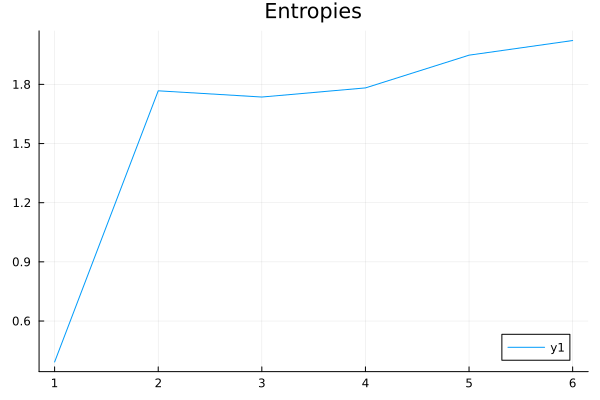

In [137]:
S_vals = model_df[ :, :Model_Thermo_State] .|> x -> x[:S]
Plots.plot( S_vals, title="Entropies" )

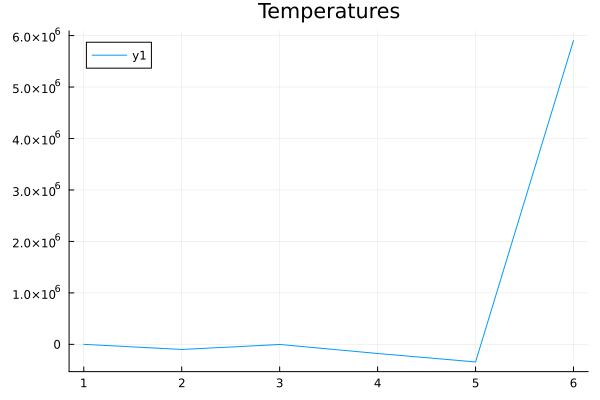

In [138]:
T_vals = model_df[ :, :Model_Thermo_State] .|> x -> x[:T]
Plots.plot( T_vals, title="Temperatures" )

In [123]:
model_df[ 298, :Flock_Model_State]

LoadError: BoundsError: attempt to access 51×5 DataFrame at index [298, :Flock_Model_State]